### Importing Statements

In [1]:
# Importing statements
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt
from music21 import *

%matplotlib inline

### Loading the Data

In [2]:
working_dir = "../datasets"
data_dir = os.path.join(working_dir, "processed_data")

In [3]:
# list of files in the data_dir
os.listdir(data_dir)

['input_notes.pkl',
 'output.pkl',
 'input.pkl',
 'output_notes.pkl',
 'pitchnames.csv']

In [4]:
# We have to load input file and output file.
with open(os.path.join(data_dir, 'input.pkl'),'rb') as f:
    X_seq_ = pickle.load(f)

with open(os.path.join(data_dir, 'output.pkl'),'rb') as f:
    y_seq_ = pickle.load(f)

In [5]:
# Printing the shape of the Data
X_seq_.shape, y_seq_.shape

((66925, 32, 1), (66925, 304))

In [6]:
# Normalize the Input
n_vocab = 304
X_seq = X_seq_/n_vocab
y_seq = y_seq_

### Splitting the Data

In [7]:
X_train, X_test, y_train,y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=True, random_state=0)

In [8]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((53540, 32, 1), (13385, 32, 1), (53540, 304), (13385, 304))

### Building first Model

In [10]:
model = Sequential([
    LSTM(units=64, activation="relu", return_sequences=True, input_shape=(X_seq.shape[1], X_seq.shape[2])),
    BatchNormalization(),
    Dropout(0.2),
    
    LSTM(units=128, activation="relu", return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),
    
    LSTM(units=256, activation="relu"),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(64),
    Dropout(0.5),
    Dense(64),
    
    Dense(n_vocab, activation="softmax")
    
])

In [11]:
# Printing the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32, 64)            16896     
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 64)            256       
_________________________________________________________________
dropout (Dropout)            (None, 32, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32, 128)           98816     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 128)           512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               3

In [12]:
# Trying Different Loss
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [13]:
# Training the model
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/10
419/419 [==============================] - 157s 375ms/step - loss: 5.1232 - val_loss: 4.8974
Epoch 2/10
419/419 [==============================] - 156s 372ms/step - loss: 4.7717 - val_loss: 4.7406
Epoch 3/10
419/419 [==============================] - 157s 374ms/step - loss: 4.7218 - val_loss: 4.6850
Epoch 4/10
419/419 [==============================] - 159s 378ms/step - loss: 4.6859 - val_loss: 4.6649
Epoch 5/10
419/419 [==============================] - 158s 378ms/step - loss: 4.6512 - val_loss: 4.6719
Epoch 6/10
419/419 [==============================] - 158s 378ms/step - loss: 4.6238 - val_loss: 4.6264
Epoch 7/10
419/419 [==============================] - 157s 376ms/step - loss: 4.5979 - val_loss: 4.5978
Epoch 8/10
419/419 [==============================] - 159s 379ms/step - loss: 4.5746 - val_loss: 4.6123
Epoch 9/10
419/419 [==============================] - 158s 377ms/step - loss: 4.5485 - val_loss: 4.5281
Epoch 10/10
419/419 [==============================] - 157s 375m

In [13]:
# Save the model

In [14]:
# Save the weights

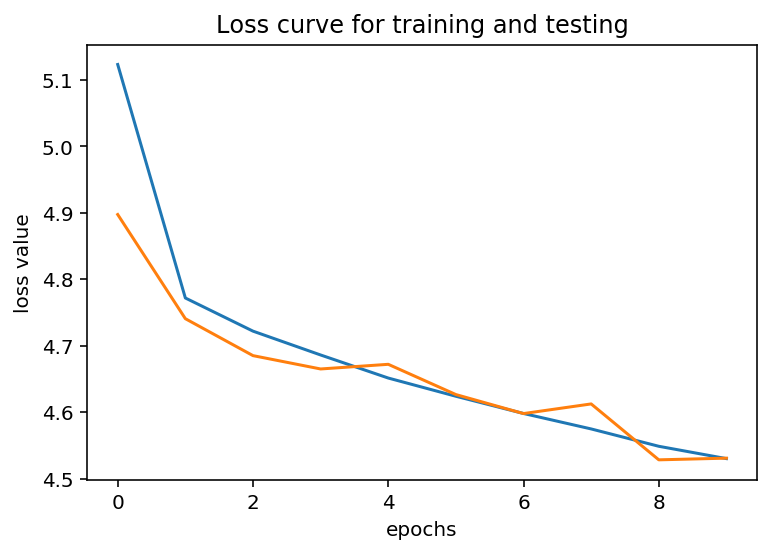

In [14]:
# Plotting the loss curve
plt.xlabel('epochs')
plt.ylabel('loss value')
plt.title('Loss curve for training and testing')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [15]:
# Generating the music
# Load all the distinct pitchnames
pitchnames = np.genfromtxt(os.path.join(os.path.join(working_dir, 'processed_data'), 'pitchnames.csv'), dtype=str, delimiter=',')

# Getting the integer id for each pitch
int_to_note = dict((number , note) for number, note in enumerate(pitchnames))

In [16]:
# predicting the output for test data.
y_pred = model.predict(X_test)

In [17]:
predicted_notes = []
for i in y_pred:
    predicted_notes.append(int_to_note[np.argmax(i)]) ############### np.argmax() returns the index of maximum value in the list.
    

In [18]:
y_seq_ = []
for i in y_seq:
    y_seq_.append(np.argmax(i))

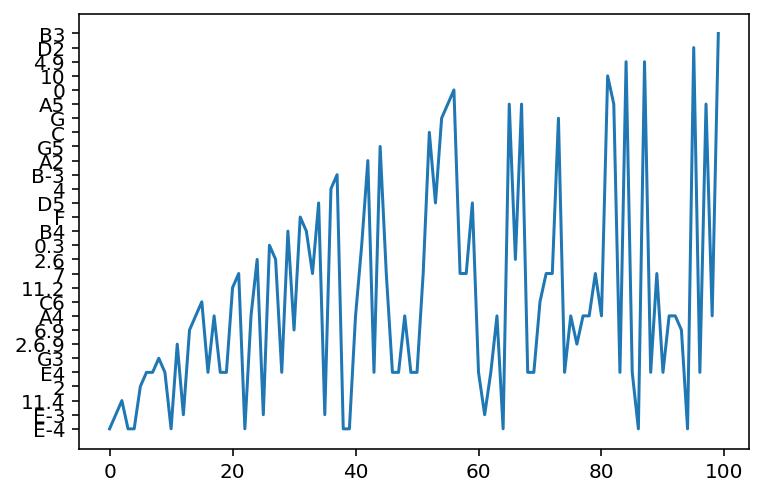

In [19]:
# plot between y_test and y_predicted
#plt.plot(y_seq_[:100])
plt.plot(predicted_notes[:100])

In [20]:
# Producing the continuous music
n = 500     ################ Number of notes to be produced.
# playing random music everytime
play = np.random.randint(0, len(X_seq_)-1)

current_notes = X_seq_[play]
result_ = []

# Generating continuous music
for index in range(n):
    # Making the input suitable for model.
    prediction_input = np.reshape(current_notes, (1, len(current_notes), 1))
    prediction_input = prediction_input/n_vocab
    
    # Predicting the next note for the current_notes
    predicted_note = model.predict(prediction_input)
    
    # Getting the most probable note value
    predicted_note_index = np.argmax(predicted_note)
    predicted_note_value = int_to_note[predicted_note_index]
    
    # Storing the notes in the result notes list
    result_.append(predicted_note_value)
    
    # Creating new Current note value
    current_notes = np.append(current_notes, predicted_note_index)
    current_notes = current_notes[1:]

In [21]:
# Splitting all the chords into notes in the result array
# Setting note's distance from the beginning.
offset = 0
output_notes = []

for i in result_:
    if '.' in i or i.isdigit():
        notes_in_chord = i.split()
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
            
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
        
    else:
        new_note = note.Note(i)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)
        
    offset += 0.5

In [22]:
# Changing the notes to stream
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='test_output.mid')

'test_output.mid'

In [24]:
# import pygame


# def play_music(midi_filename):
#     '''Stream music_file in a blocking manner'''
#     clock = pygame.time.Clock()
#     pygame.mixer.music.load(midi_filename)
#     pygame.mixer.music.play()
#     while pygame.mixer.music.get_busy():
#         clock.tick(30) # check if playback has finished
    
# midi_filename = 'test_output.mid'

# # mixer config
# freq = 44100  # audio CD quality
# bitsize = -16   # unsigned 16 bit
# channels = 2  # 1 is mono, 2 is stereo
# buffer = 1024   # number of samples
# pygame.mixer.init(freq, bitsize, channels, buffer)

# # optional volume 0 to 1.0
# pygame.mixer.music.set_volume(0.8)

# # listen for interruptions
# try:
#     # use the midi file you just saved
#     play_music(midi_filename)
# except KeyboardInterrupt:
#     # if user hits Ctrl/C then exit
#     # (works only in console mode)
#     pygame.mixer.music.fadeout(1000)
#     pygame.mixer.music.stop()
#     raise SystemExit